<a href="https://colab.research.google.com/github/AubLambert/FraudDetection/blob/hieu/Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [59]:
!pip install catplot

# Basic Analysis

## Import Data

In [60]:
# Set pandas option to display all columns
pd.set_option('display.max_columns', None)

# Optional: Set the width to avoid line breaks
pd.set_option('display.width', None)

df = pd.read_csv('fraudTrain.csv', on_bad_lines='warn')  # or 'skip' or 'error'
df

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,1296670,2020-06-21 12:12:08,30263540414123,fraud_Reichel Inc,entertainment,15.56,Erik,Patterson,M,162 Jessica Row Apt. 072,Hatch,UT,84735,37.7175,-112.4777,258,Geoscientist,1961-11-24,440b587732da4dc1a6395aba5fb41669,1371816728,36.841266,-111.690765,0
1296671,1296671,2020-06-21 12:12:19,6011149206456997,fraud_Abernathy and Sons,food_dining,51.70,Jeffrey,White,M,8617 Holmes Terrace Suite 651,Tuscarora,MD,21790,39.2667,-77.5101,100,"Production assistant, television",1979-12-11,278000d2e0d2277d1de2f890067dcc0a,1371816739,38.906881,-78.246528,0
1296672,1296672,2020-06-21 12:12:32,3514865930894695,fraud_Stiedemann Ltd,food_dining,105.93,Christopher,Castaneda,M,1632 Cohen Drive Suite 639,High Rolls Mountain Park,NM,88325,32.9396,-105.8189,899,Naval architect,1967-08-30,483f52fe67fabef353d552c1e662974c,1371816752,33.619513,-105.130529,0
1296673,1296673,2020-06-21 12:13:36,2720012583106919,"fraud_Reinger, Weissnat and Strosin",food_dining,74.90,Joseph,Murray,M,42933 Ryan Underpass,Manderson,SD,57756,43.3526,-102.5411,1126,Volunteer coordinator,1980-08-18,d667cdcbadaaed3da3f4020e83591c83,1371816816,42.788940,-103.241160,0


In [61]:
df = df.drop('Unnamed: 0', axis=1)

## Descriptive Statistics

In [62]:
df.describe()

,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06
mean,4.171920e+17,7.035104e+01,4.880067e+04,3.853762e+01,-9.022634e+01,8.882444e+04,1.349244e+09,3.853734e+01,-9.022646e+01,5.788652e-03
std,1.308806e+18,1.603160e+02,2.689322e+04,5.075808e+00,1.375908e+01,3.019564e+05,1.284128e+07,5.109788e+00,1.377109e+01,7.586269e-02
min,6.041621e+10,1.000000e+00,1.257000e+03,2.002710e+01,-1.656723e+02,2.300000e+01,1.325376e+09,1.902779e+01,-1.666712e+02,0.000000e+00
25%,1.800429e+14,9.650000e+00,2.623700e+04,3.462050e+01,-9.679800e+01,7.430000e+02,1.338751e+09,3.473357e+01,-9.689728e+01,0.000000e+00
50%,3.521417e+15,4.752000e+01,4.817400e+04,3.935430e+01,-8.747690e+01,2.456000e+03,1.349250e+09,3.936568e+01,-8.743839e+01,0.000000e+00
75%,4.642255e+15,8.314000e+01,7.204200e+04,4.194040e+01,-8.015800e+01,2.032800e+04,1.359385e+09,4.195716e+01,-8.023680e+01,0.000000e+00
max,4.992346e+18,2.894890e+04,9.978300e+04,6.669330e+01,-6.795030e+01,2.906700e+06,1.371817e+09,6.751027e+01,-6.695090e+01,1.000000e+00


In [63]:
df.shape

(1296675, 22)

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1296675 non-null  object 
 1   cc_num                 1296675 non-null  int64  
 2   merchant               1296675 non-null  object 
 3   category               1296675 non-null  object 
 4   amt                    1296675 non-null  float64
 5   first                  1296675 non-null  object 
 6   last                   1296675 non-null  object 
 7   gender                 1296675 non-null  object 
 8   street                 1296675 non-null  object 
 9   city                   1296675 non-null  object 
 10  state                  1296675 non-null  object 
 11  zip                    1296675 non-null  int64  
 12  lat                    1296675 non-null  float64
 13  long                   1296675 non-null  float64
 14  city_pop          

In [65]:
df.isnull().sum()

,0
trans_date_trans_time,0
cc_num,0
merchant,0
category,0
amt,0
first,0
last,0
gender,0
street,0
city,0


In [66]:
df.select_dtypes(include=['int64', 'float64']).nunique()

,0
cc_num,983
amt,52928
zip,970
lat,968
long,969
city_pop,879
unix_time,1274823
merch_lat,1247805
merch_long,1275745
is_fraud,2


In [67]:
df.select_dtypes(include=['object', 'category']).nunique()

,0
trans_date_trans_time,1274791
merchant,693
category,14
first,352
last,481
gender,2
street,983
city,894
state,51
job,494


# EDA

In [68]:
# Create a copy for EDA
df_viz = df.copy()

## Data Transformation

### Fraud Distribution

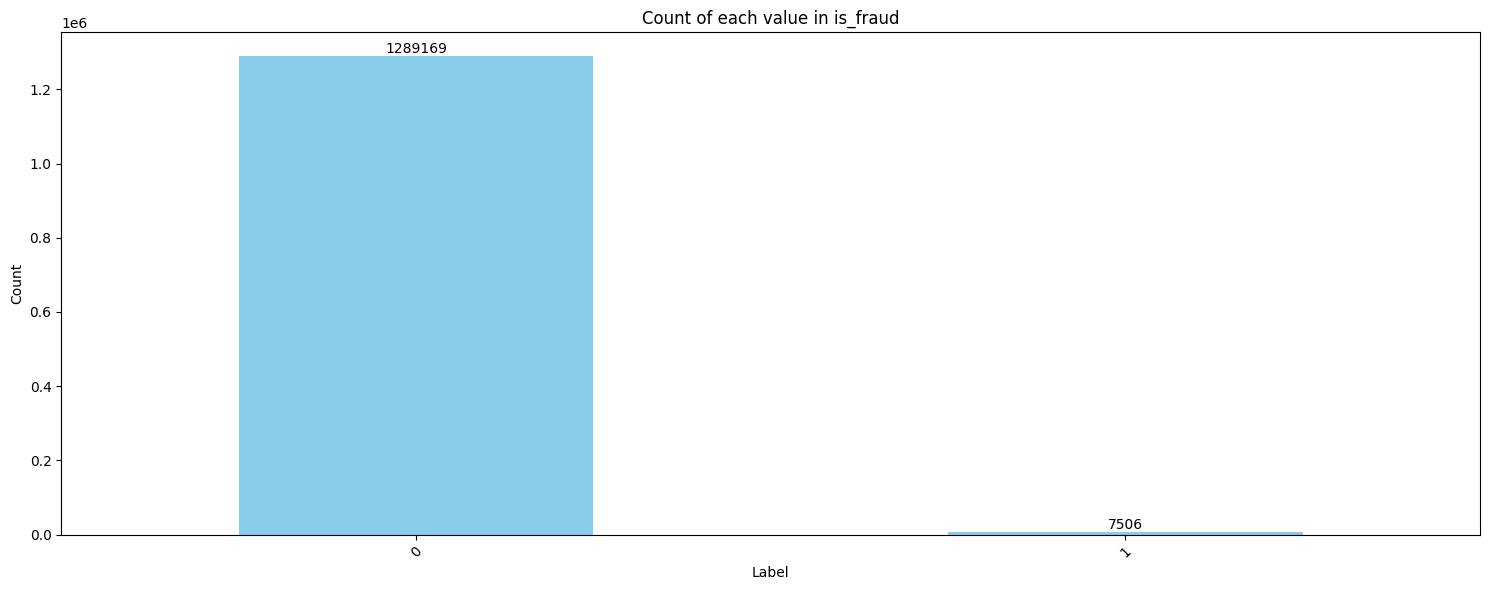

In [69]:
def cat_plot(df, column):
    counts = df[column].value_counts()

    plt.figure(figsize=(15, 6))
    ax = counts.plot(kind='bar', color='skyblue')

    # Add labels on top of bars
    for i, v in enumerate(counts):
        ax.text(i, v + 0.5, str(v), ha='center', va='bottom', fontsize=10)

    plt.title(f"Count of each value in {column}")
    plt.xlabel("Label")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

cat_plot(df_viz, "is_fraud")

In [70]:
fraud_percent = (df['is_fraud'] == 1).sum()/(df.shape[0])

print(f"Fraud Percentage: {fraud_percent * 100:.5f}%")

Fraud Percentage: 0.57887%


### Correlation

#### Numerical correlation

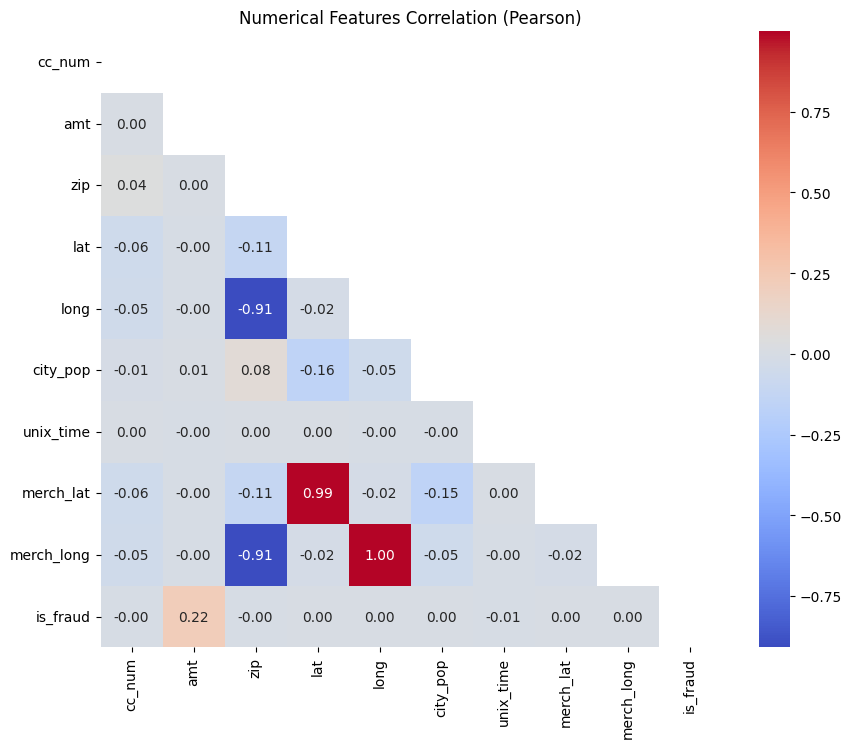

In [71]:
def num_corr(df):
    num_cols = df.select_dtypes(include=['int64', 'float64'])

    # Pearson correlation
    corr_num = num_cols.corr()

    # Mask upper triangle
    mask = np.triu(np.ones_like(corr_num, dtype=bool))

    plt.figure(figsize=(10,8))
    sns.heatmap(corr_num, mask=mask, cmap="coolwarm", annot=True, fmt=".2f", cbar=True)
    plt.title("Numerical Features Correlation (Pearson)")
    plt.show()

num_corr(df_viz)

#### Categorical correlation

In [72]:
df_viz_samp = df_viz.drop(["trans_date_trans_time", "dob", "trans_num"], axis=1)

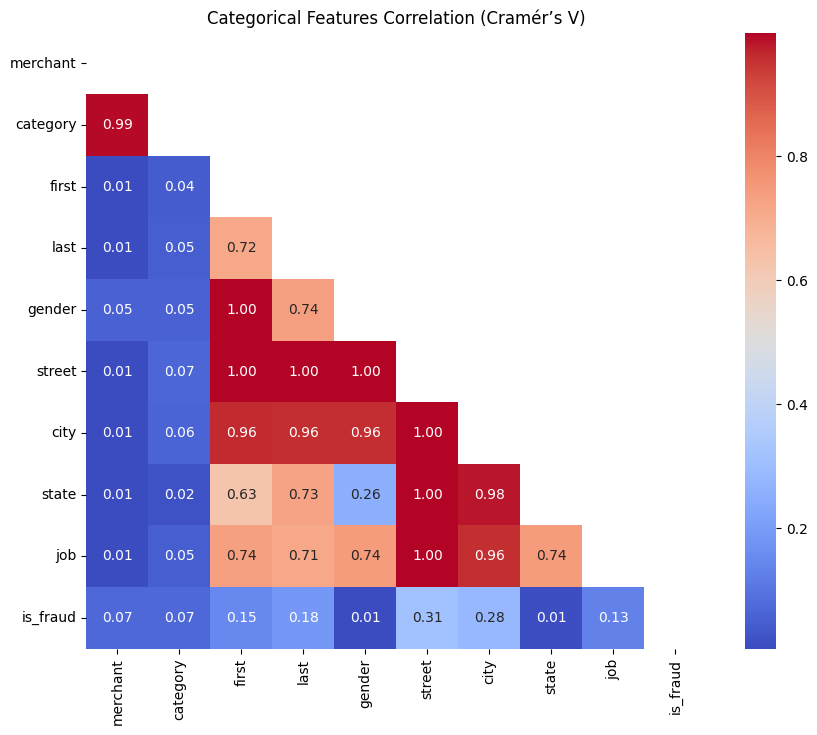

In [73]:
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency

def cat_corr(df):
    def cramers_v(x, y):
        confusion_matrix = pd.crosstab(x, y)
        chi2 = chi2_contingency(confusion_matrix)[0]
        n = confusion_matrix.sum().sum()
        phi2 = chi2/n
        r,k = confusion_matrix.shape
        phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
        rcorr = r - ((r-1)**2)/(n-1)
        kcorr = k - ((k-1)**2)/(n-1)
        return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

    # Select categorical columns

    df_viz_samp = df.sample(frac=0.1, random_state=42)
    df_viz_samp["is_fraud"] = df_viz_samp["is_fraud"].astype("category")
    cat_cols = df_viz_samp.select_dtypes(include=["object", "category"]).astype("category")

    # Compute Cramér’s V matrix
    corr_cat = pd.DataFrame(np.zeros((len(cat_cols.columns), len(cat_cols.columns))),
                            index=cat_cols.columns, columns=cat_cols.columns)

    for c1 in cat_cols.columns:
        for c2 in cat_cols.columns:
            corr_cat.loc[c1, c2] = cramers_v(cat_cols[c1], cat_cols[c2])

    # Mask upper triangle
    mask = np.triu(np.ones_like(corr_cat, dtype=bool))

    plt.figure(figsize=(10,8))
    sns.heatmap(corr_cat, mask=mask, cmap="coolwarm", annot=True, fmt=".2f", cbar=True)
    plt.title("Categorical Features Correlation (Cramér’s V)")
    plt.show()

cat_corr(df_viz_samp)

In [74]:
df_viz_2 = df_viz.copy()

### Date and Time Heatmap


#### Transaction

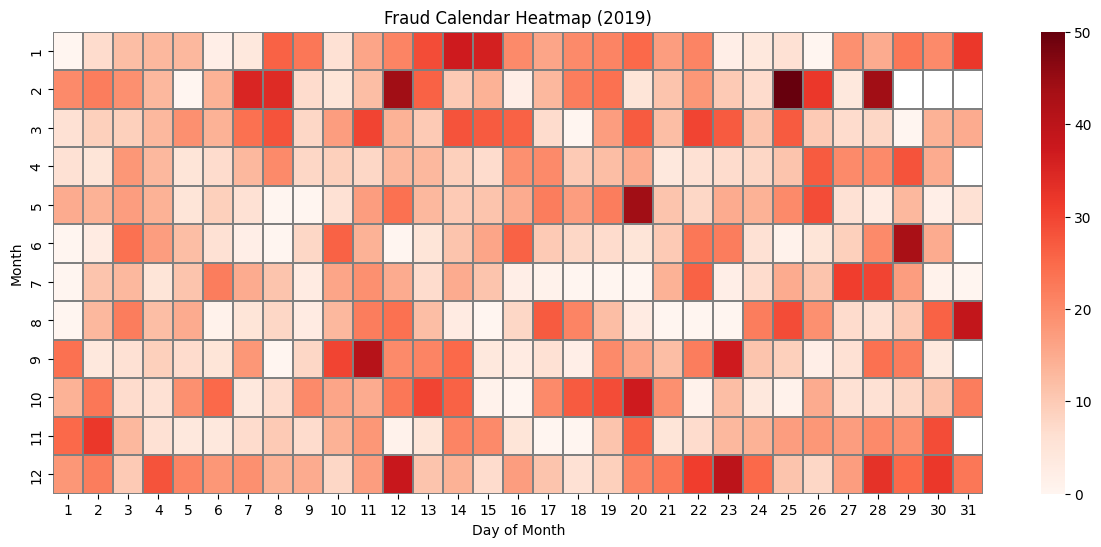

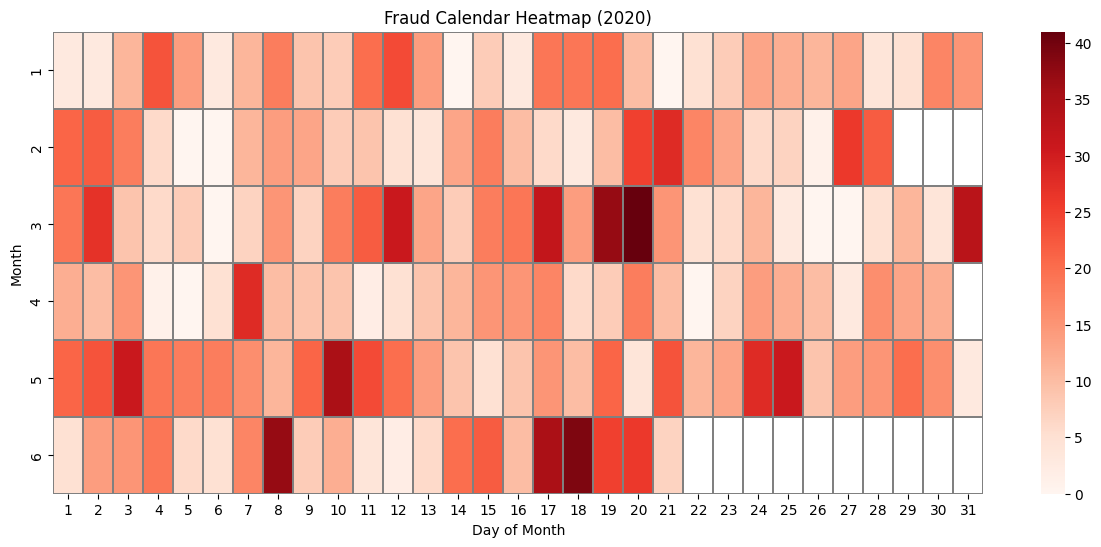

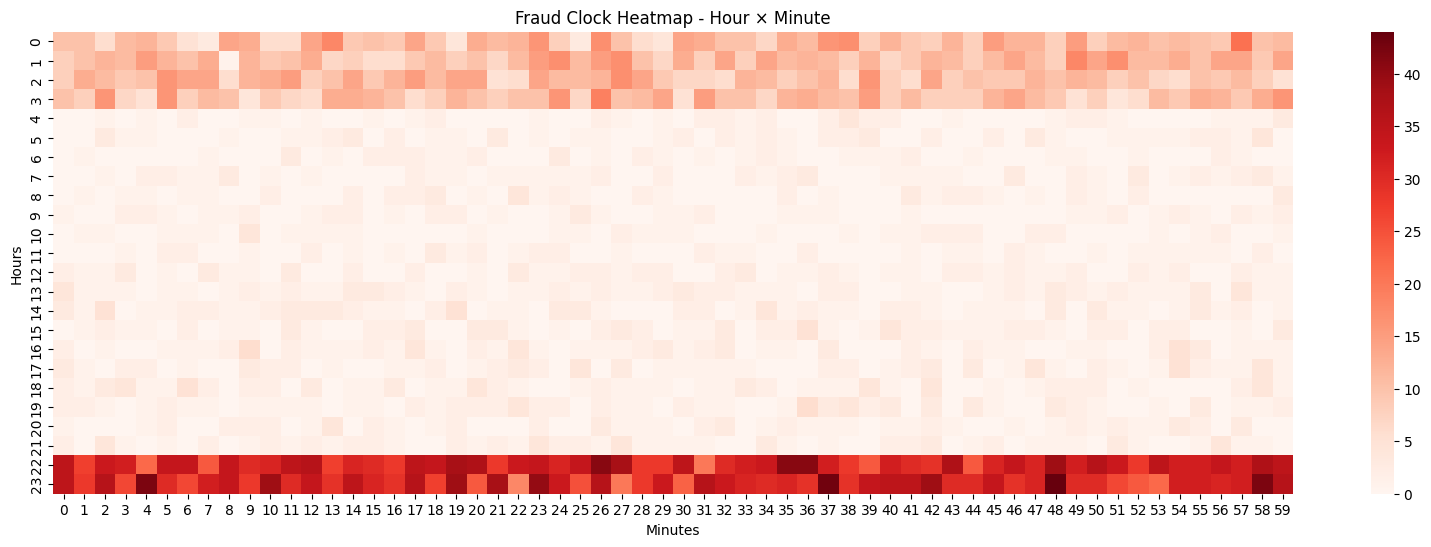

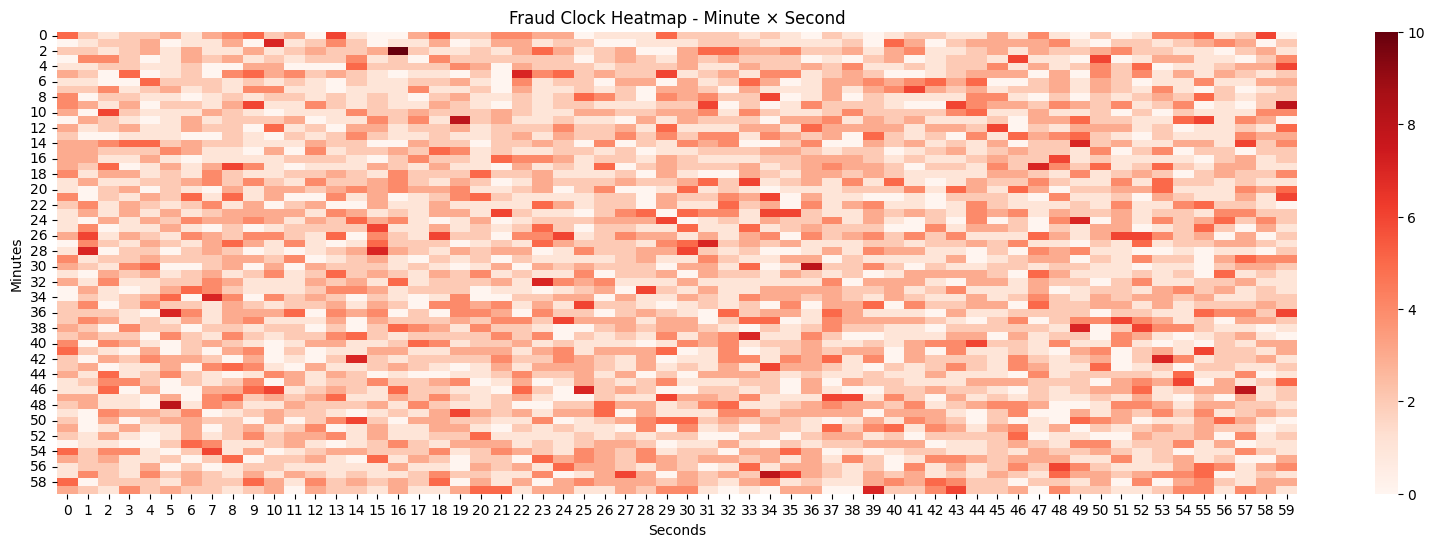

In [75]:
df_viz["trans_date_trans_time"] = pd.to_datetime(df_viz["trans_date_trans_time"])
df_viz["year"] = df_viz["trans_date_trans_time"].dt.year
df_viz["month"] = df_viz["trans_date_trans_time"].dt.month
df_viz["day"] = df_viz["trans_date_trans_time"].dt.day
df_viz["hour"] = df_viz["trans_date_trans_time"].dt.hour
df_viz["minute"] = df_viz["trans_date_trans_time"].dt.minute
df_viz["second"] = df_viz["trans_date_trans_time"].dt.second

# =====================================================
# 1) CALENDAR HEATMAP (Year × Month × Day)
# =====================================================
fraud_calendar = df_viz.groupby(["year","month","day"])["is_fraud"].sum().reset_index()

for yr in sorted(fraud_calendar["year"].unique()):
    pivoted = fraud_calendar[fraud_calendar["year"]==yr].pivot(
        index="month", columns="day", values="is_fraud"
    )

    plt.figure(figsize=(15,6))
    sns.heatmap(pivoted, cmap="Reds", cbar=True, linewidths=0.1, linecolor="grey")
    plt.title(f"Fraud Calendar Heatmap ({yr})")
    plt.xlabel("Day of Month")
    plt.ylabel("Month")
    plt.show()

# =====================================================
# 2) CLOCK HEATMAP (Hour × Minute)
# =====================================================

fraud_clock_min = df_viz.groupby(["hour","minute"])["is_fraud"].sum().reset_index()

pivoted_clock_min = fraud_clock_min.pivot_table(
    index="hour", columns="minute", values="is_fraud", fill_value=0
)

plt.figure(figsize=(20,6))
sns.heatmap(pivoted_clock_min, cmap="Reds", cbar=True)
plt.title("Fraud Clock Heatmap - Hour × Minute")
plt.xlabel("Minutes")
plt.ylabel("Hours")
plt.show()

fraud_clock_sec = df_viz.groupby(["minute","second"])["is_fraud"].sum().reset_index()

pivoted_clock_sec = fraud_clock_sec.pivot_table(
    index="minute", columns="second", values="is_fraud", fill_value=0
)

plt.figure(figsize=(20,6))
sns.heatmap(pivoted_clock_sec, cmap="Reds", cbar=True)
plt.title("Fraud Clock Heatmap - Minute × Second")
plt.xlabel("Seconds")
plt.ylabel("Minutes")
plt.show()

#### DoB

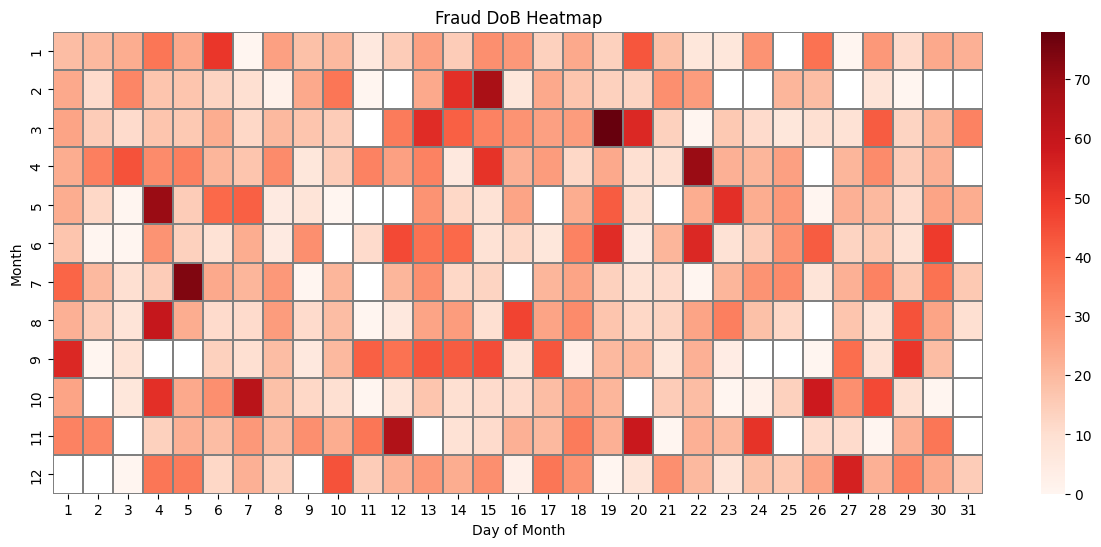

In [76]:
df_viz["dob"] = pd.to_datetime(df_viz["dob"])
df_viz["dob_year"] = df_viz["dob"].dt.year
df_viz["dob_month"] = df_viz["dob"].dt.month
df_viz["dob_day"] = df_viz["dob"].dt.day

fraud_dob = df_viz.groupby(["dob_month","dob_day"])["is_fraud"].sum().reset_index()

pivoted = fraud_dob.pivot(
    index="dob_month", columns="dob_day", values="is_fraud"
)

plt.figure(figsize=(15,6))
sns.heatmap(pivoted, cmap="Reds", cbar=True, linewidths=0.1, linecolor="grey")
plt.title(f"Fraud DoB Heatmap")
plt.xlabel("Day of Month")
plt.ylabel("Month")
plt.show()

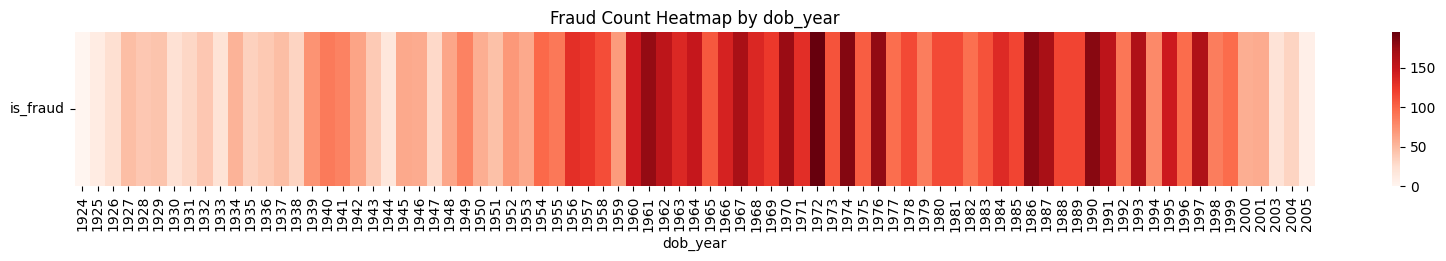

In [77]:
def feature_to_target(df, column):
    partition = df.groupby(column)["is_fraud"].sum().reset_index()

    # reshape into 1-row dataframe
    heatmap_data = partition.set_index(column).T

    plt.figure(figsize=(20, 2))
    sns.heatmap(
        heatmap_data,
        cmap="Reds",
        annot=False,  # disable is_fraud count labels
        cbar=True
    )
    plt.title(f"Fraud Count Heatmap by {column}")
    plt.yticks(rotation=0)
    plt.show()

feature_to_target(df_viz, "dob_year")

### Concatenate customer_name

In [78]:
df_viz_2["customer_name"] = df_viz_2["first"].str.cat(df_viz_2["last"], sep=' ')

In [79]:
df_viz_2["customer_name"].nunique()

973

In [80]:
df_viz_2 = df_viz_2.drop(["first", "last"], axis=1)

### Split merchant prefix

In [81]:
df_viz_2["merchant"].str.startswith("fraud_").sum()

np.int64(1296675)

In [82]:
# df_viz["merchant"] = df_viz["merchant"].str.removeprefix("fraud_")
# df_viz["merchant"].nunique()

### Split street components

In [83]:
splits = df_viz_2["street"].str.split(" ", expand=True)

# Assign to new columns sequentially
df_viz_2["str_number"]    = splits[0]
df_viz_2["str_name"]      = splits[1]
df_viz_2["str_type"]      = splits[2]
df_viz_2["building_type"] = splits[3]
df_viz_2["room_number"]   = splits[4]

df_viz_2 = df_viz_2.drop('street', axis=1)

In [84]:
df_viz_2.nunique()

,0
trans_date_trans_time,1274791
cc_num,983
merchant,693
category,14
amt,52928
gender,2
city,894
state,51
zip,970
lat,968


### Drop city

In [85]:
df_viz_2 = df_viz_2.drop("city", axis=1)

### Split zip prefix

In [86]:
df_viz_2["zip"] = df_viz_2["zip"].astype(str).str.zfill(5)

# Extract first 3 digits (ZIP prefix / metro area)
df_viz_2["zip_prefix"] = df_viz_2["zip"].str[:3]

In [87]:
df_viz_2["zip_prefix"].nunique()

526

In [88]:
df_viz_2["zip_prefix"].astype(int)
df_viz_2 = df_viz_2.drop("zip", axis=1)

### Calculate distance (km) between merchants and customers

In [89]:
def haversine_vectorized(lat1, lon1, lat2, lon2):
    # Convert to radians
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Earth radius in kilometers
    return r * c

# Example usage with your DataFrame df
df_viz_2['distance_km'] = haversine_vectorized(
    df_viz_2['lat'], df_viz_2['long'], df_viz_2['merch_lat'], df_viz_2['merch_long']
)

df_viz_2 = df_viz_2.drop(["lat", "long", "merch_lat", "merch_long"], axis=1)

### Overwrite job

In [90]:
df_viz_2["job"].nunique()

494

In [91]:
job_splits = df_viz_2["job"].str.split(",")

# Find maximum number of jobs in any row
max_jobs = job_splits.map(len).max()

# Create new DataFrame with expanded columns
job_df = pd.DataFrame(job_splits.tolist(), index=df.index)

# Rename columns as job1, job2, ...
job_df.columns = [f"job{i+1}" for i in range(max_jobs)]

# Concatenate back with original df
df_sample = pd.concat([df_viz_2.drop(columns=["job"]), job_df], axis=1)

In [92]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1296675 non-null  object 
 1   cc_num                 1296675 non-null  int64  
 2   merchant               1296675 non-null  object 
 3   category               1296675 non-null  object 
 4   amt                    1296675 non-null  float64
 5   gender                 1296675 non-null  object 
 6   state                  1296675 non-null  object 
 7   city_pop               1296675 non-null  int64  
 8   dob                    1296675 non-null  object 
 9   trans_num              1296675 non-null  object 
 10  unix_time              1296675 non-null  int64  
 11  is_fraud               1296675 non-null  int64  
 12  customer_name          1296675 non-null  object 
 13  str_number             1296675 non-null  object 
 14  str_name          

In [93]:
df_sample["job1"].unique()

array(['Psychologist', 'Special educational needs teacher',
       'Nature conservation officer', 'Patent attorney',
       'Dance movement psychotherapist', 'Transport planner',
       'Arboriculturist', 'Designer', 'Public affairs consultant',
       'Pathologist', 'IT trainer', 'Systems developer', 'Engineer',
       'Systems analyst', 'Naval architect', 'Radiographer',
       'Programme researcher', 'Energy engineer', 'Event organiser',
       'Operational researcher', 'Market researcher', 'Probation officer',
       'Leisure centre manager', 'Corporate investment banker',
       'Therapist', 'Call centre manager', 'Police officer',
       'Education officer', 'Physiotherapist', 'Network engineer',
       'Forensic psychologist', 'Geochemist',
       'Armed forces training and education officer', 'Optician',
       'Librarian', 'Fine artist', 'Scientist', 'Research officer',
       'Tourism officer', 'Human resources officer', 'Surveyor',
       'Applications developer', 'Video edi

In [94]:
df_sample["job2"].unique()

array([' counselling', None, ' multimedia', ' land', ' diagnostic',
       ' broadcasting/film/video', ' occupational', ' museum',
       ' furniture', ' dispensing', ' forensic', ' public',
       ' research (maths)', ' trade union', ' minerals',
       ' political party', ' mining', ' community', ' medical',
       ' technical sales', ' jewellery', ' electronics', ' Scotland',
       ' engineering', ' broadcasting (operations)', ' museum/gallery',
       ' biomedical', ' magazine features', ' education', ' audiological',
       ' charities/voluntary organisations', ' horticultural', ' radio',
       ' communications', ' English as a foreign language', ' structural',
       ' sports', ' early years/pre', ' academic', ' clinical',
       ' building services', ' sport and exercise', ' newspaper',
       ' hospital', ' child', ' secondary school', ' film/video',
       ' ceramics/pottery', ' advertising', " children's",
       ' interior/spatial', ' chartered', ' airline',
       ' speci

In [95]:
# Overwrite 'job' with only the first element before the comma
df_viz_2["job"] = df_viz_2["job"].str.split(",").str[0].str.strip()

In [96]:
df_viz_2["job"]

,job
0,Psychologist
1,Special educational needs teacher
2,Nature conservation officer
3,Patent attorney
4,Dance movement psychotherapist
...,...
1296670,Geoscientist
1296671,Production assistant
1296672,Naval architect
1296673,Volunteer coordinator


### Calculating age

In [97]:
import pandas as pd
from datetime import datetime

# Ensure dob is datetime
df_viz_2["dob"] = pd.to_datetime(df_viz_2["dob"])
df_viz_2["dob_year"] = df_viz_2["dob"].dt.year

# Calculate age based on transaction year
df_viz_2["trans_date_trans_time"] = pd.to_datetime(df_viz_2["trans_date_trans_time"])
df_viz_2["year"] = df_viz_2["trans_date_trans_time"].dt.year

df_viz_2["age"] = df_viz_2["year"] - df_viz_2["dob_year"]

# Drop the intermediate dob_year column
df_viz_2 = df_viz_2.drop("dob_year", axis=1)

### Number of cc per customer

In [ ]:
# Number of unique cards per customer
df_viz_2["n_cc"] = df_viz_2.groupby("customer_name")["cc_num"].transform("nunique")

### Drop datetime columns (trans_date_trans_time, dob), trans_num

#### Rewrite unix_time

In [98]:
# As the original unix_time is not appropriate, I will drop it
df_viz_2 = df_viz_2.drop("unix_time", axis=1)

In [99]:
df_viz_2["trans_date_trans_time"] = pd.to_datetime(df_viz_2["trans_date_trans_time"])

# Create a new column with unix_time (seconds since epoch)
df_viz_2["unix_time"] = df_viz_2["trans_date_trans_time"].astype(int) // 10**9

#### Drop columns

In [100]:
df_viz_2 = df_viz_2.drop(["trans_date_trans_time", "dob", "trans_num"], axis=1)

### Correlation after transformation

In [101]:
target_col = "is_fraud"   # replace with your target column name

# Move target column to the end
cols = [c for c in df_viz_2.columns if c != target_col] + [target_col]
df_viz_2 = df_viz_2[cols]

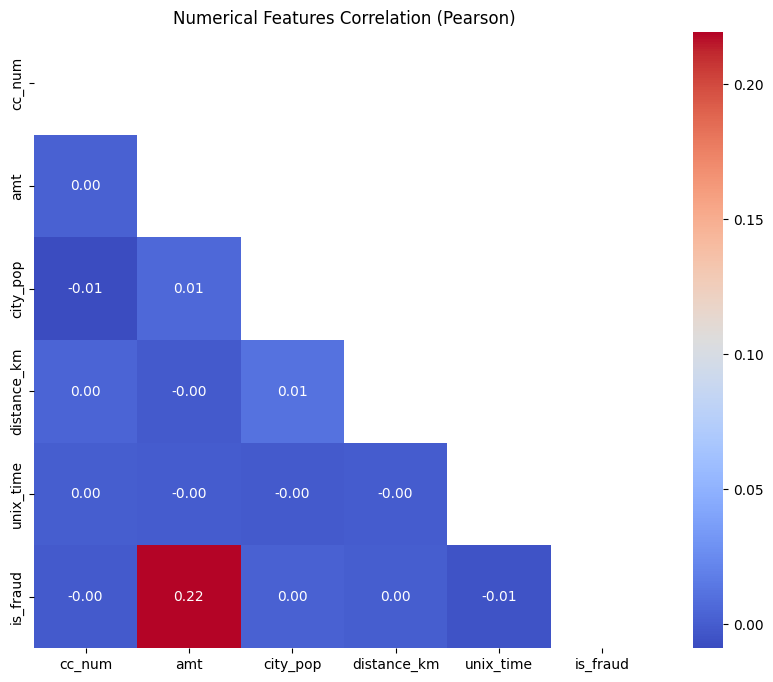

In [102]:
num_corr(df_viz_2)

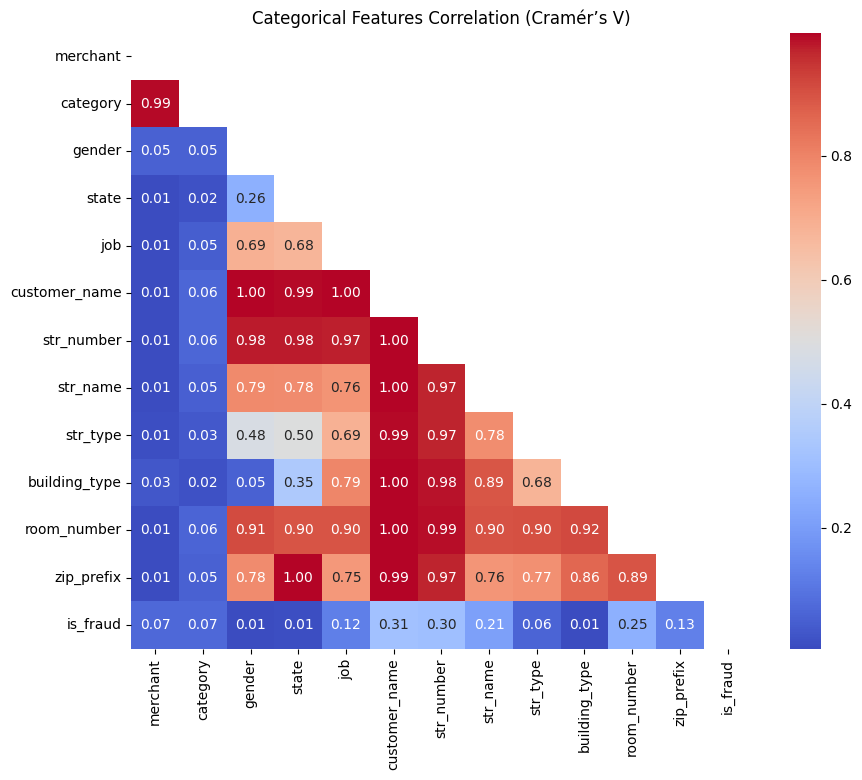

In [103]:
cat_corr(df_viz_2)

In [104]:
df_viz_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 20 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   cc_num         1296675 non-null  int64  
 1   merchant       1296675 non-null  object 
 2   category       1296675 non-null  object 
 3   amt            1296675 non-null  float64
 4   gender         1296675 non-null  object 
 5   state          1296675 non-null  object 
 6   city_pop       1296675 non-null  int64  
 7   job            1296675 non-null  object 
 8   customer_name  1296675 non-null  object 
 9   str_number     1296675 non-null  object 
 10  str_name       1296675 non-null  object 
 11  str_type       1296675 non-null  object 
 12  building_type  633258 non-null   object 
 13  room_number    633258 non-null   object 
 14  zip_prefix     1296675 non-null  object 
 15  distance_km    1296675 non-null  float64
 16  year           1296675 non-null  int32  
 17  age     

## Relationship Analysis

### Fraud Rate by Category Spending

In [105]:
fraud_by_cat_amt = (
    df_viz_2.groupby("category")
    .agg(
        total_spent=("amt", "mean"),
        fraud_cases=("is_fraud", "sum"),
        total_transactions=("is_fraud", "count")
    )
    .reset_index()
)

fraud_by_cat_amt["fraud_rate"] = (
    fraud_by_cat_amt["fraud_cases"] / fraud_by_cat_amt["total_transactions"]
)


/tmp/ipython-input-441193628.py:6: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



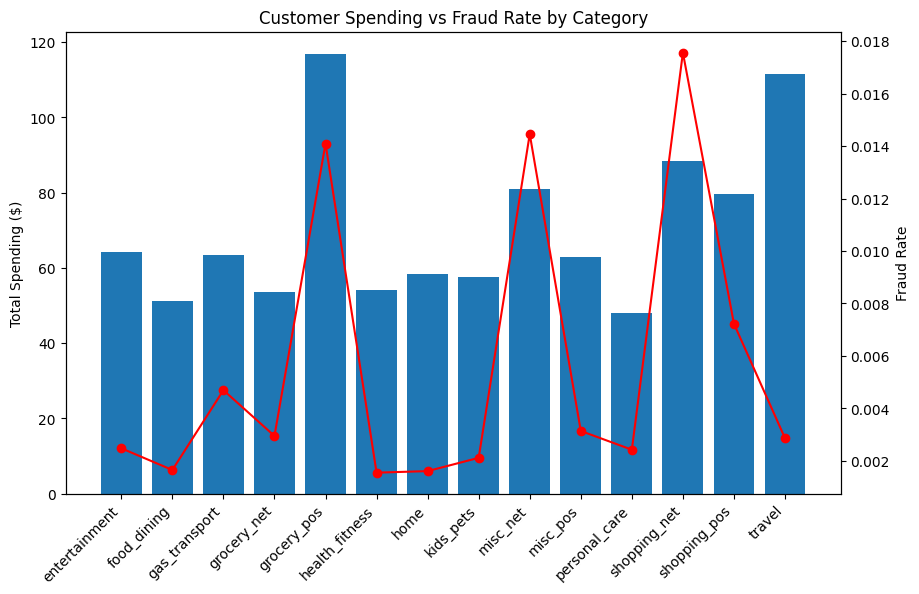

In [106]:
fig, ax1 = plt.subplots(figsize=(10,6))

# Bar for spending
ax1.bar(fraud_by_cat_amt["category"], fraud_by_cat_amt["total_spent"])
ax1.set_ylabel("Total Spending ($)")
ax1.set_xticklabels(fraud_by_cat_amt["category"], rotation=45, ha="right")

# Second axis for fraud rate
ax2 = ax1.twinx()
ax2.plot(fraud_by_cat_amt["category"], fraud_by_cat_amt["fraud_rate"], color="red", marker="o")
ax2.set_ylabel("Fraud Rate")

plt.title("Customer Spending vs Fraud Rate by Category")
plt.show()

###

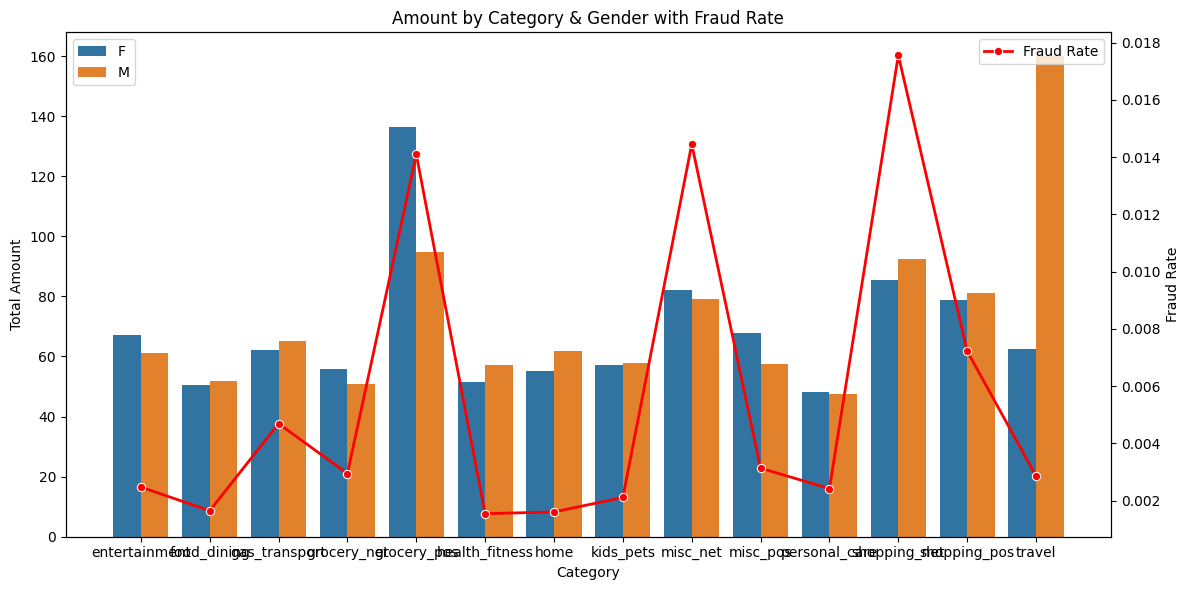

In [107]:
# --- Group data for bar plot ---
amt_group = df_viz_2.groupby(["category", "gender"])["amt"].mean().reset_index()

# --- Group data for fraud rate ---
fraud_group = df_viz_2.groupby("category")["is_fraud"].mean().reset_index()
# mean(is_fraud) = count(is_fraud==1)/total count

# --- Plot ---
fig, ax1 = plt.subplots(figsize=(12,6))

# Barplot: amount by category & gender
sns.barplot(data=amt_group, x="category", y="amt", hue="gender", ax=ax1)

# Secondary axis for fraud rate
ax2 = ax1.twinx()
sns.lineplot(data=fraud_group, x="category", y="is_fraud",
             marker="o", color="red", linewidth=2, ax=ax2, label="Fraud Rate")

# Labels
ax1.set_ylabel("Total Amount")
ax2.set_ylabel("Fraud Rate")
ax1.set_xlabel("Category")

# Show both legends
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.title("Amount by Category & Gender with Fraud Rate")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Fraud Rate by Category and Distance

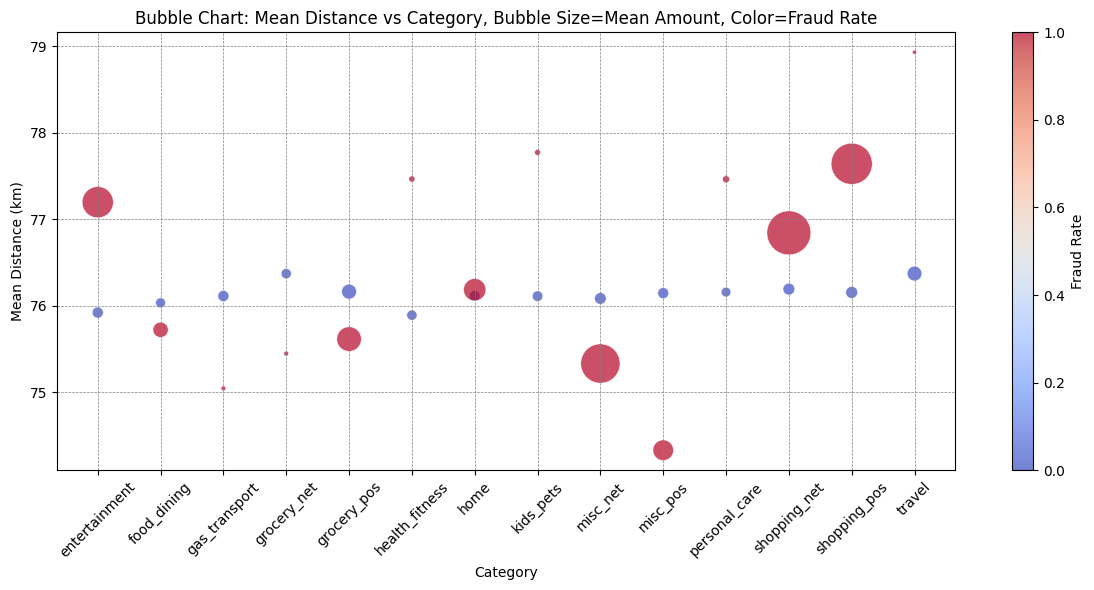

In [108]:
# --- Aggregate data ---
fraud_by_km_n_amt = df_viz_2.groupby(["category", "is_fraud"]).agg(
    mean_distance=("distance_km", "mean"),
    mean_amt=("amt", "mean"),
).reset_index()

# --- Bubble chart ---
plt.figure(figsize=(12,6))
scatter = plt.scatter(
    x=fraud_by_km_n_amt["category"],
    y=fraud_by_km_n_amt["mean_distance"],
    s=fraud_by_km_n_amt["mean_amt"],
    c=fraud_by_km_n_amt["is_fraud"],      # hue by fraud rate
    cmap="coolwarm",
    alpha=0.7,
    edgecolors="w",
    linewidth=0.5
)

plt.xlabel("Category")
plt.ylabel("Mean Distance (km)")
plt.title("Bubble Chart: Mean Distance vs Category, Bubble Size=Mean Amount, Color=Fraud Rate")
plt.xticks(rotation=45)

# Colorbar
cbar = plt.colorbar(scatter)
cbar.set_label("Fraud Rate")

plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [109]:
df_state = df_viz_2.groupby("state")["is_fraud"].sum().reset_index()

fig = px.choropleth(df_state,
                    locations='state',
                    locationmode='USA-states',
                    color='is_fraud',
                    scope="usa",
                    color_continuous_scale="Reds",
                    labels={'fraud_rate':'Fraud Rate'})

fig.update_layout(title_text="US Fraud Rate by State", geo_scope='usa')
fig.show()

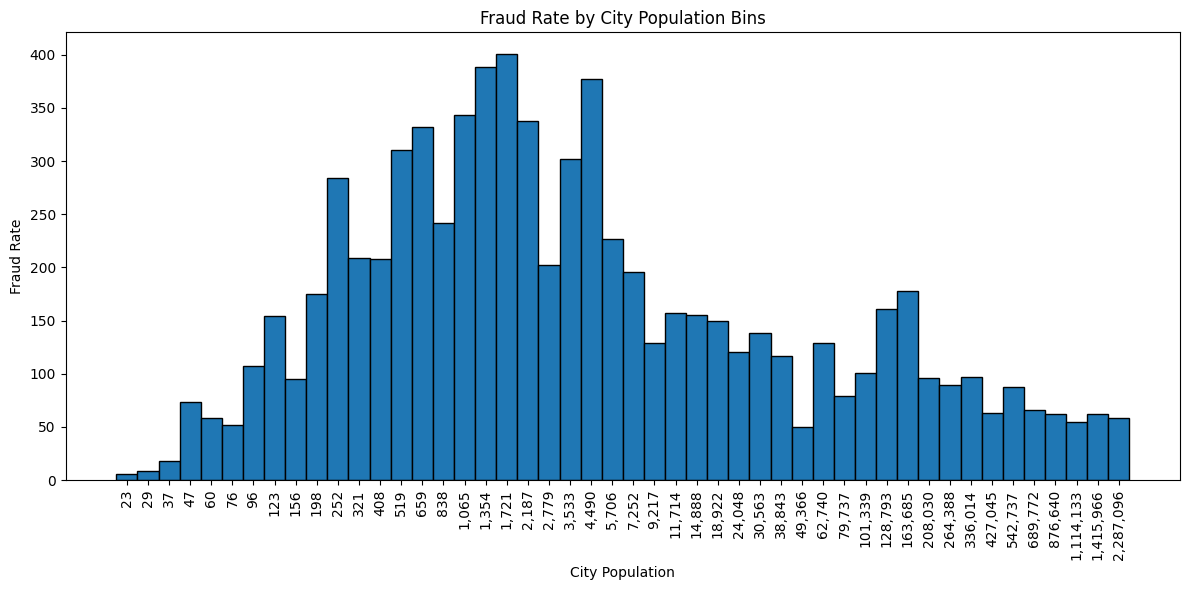

In [110]:
 # Define log-spaced bins
bins = np.logspace(np.log10(df_viz_2["city_pop"].min()), np.log10(df_viz_2["city_pop"].max()), 50)

# Compute fraud rate per bin
df['bin'] = pd.cut(df_viz_2["city_pop"], bins)
fraud_rate = df.groupby('bin', observed=True)["is_fraud"].sum()

# Plot
plt.figure(figsize=(12,6))
plt.bar(range(len(fraud_rate)), fraud_rate, width=1.0, edgecolor='k')
plt.xticks(ticks=range(len(fraud_rate)), labels=[f"{int(interval.left):,}" for interval in fraud_rate.index], rotation=90)
plt.xlabel("City Population")
plt.ylabel("Fraud Rate")
plt.title("Fraud Rate by City Population Bins")
plt.tight_layout()
plt.show()

### Fraud Rate by Credit card owned and House owned

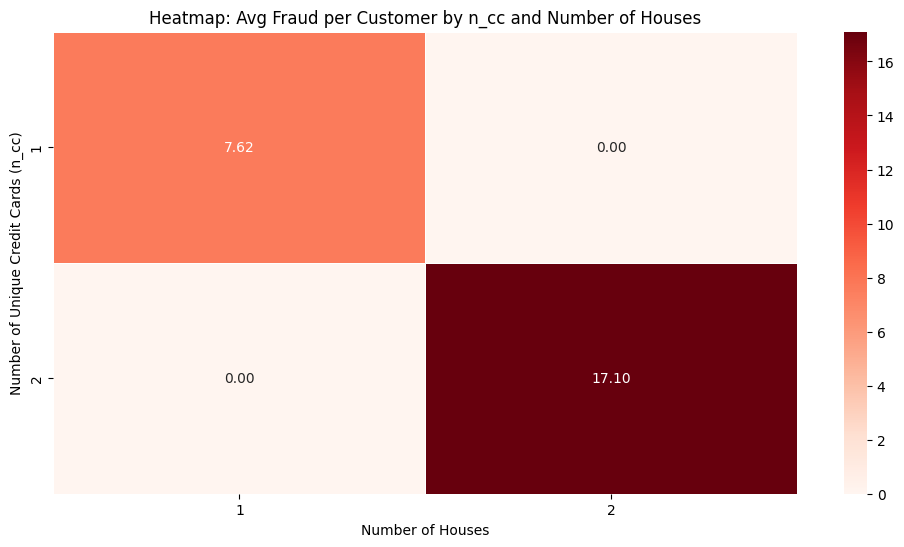

In [138]:
# --- Aggregate data per customer ---
customer_agg = df_viz_2.groupby(["customer_name", "n_cc"]).agg(
    n_house=("str_name", "nunique"),
    fraud_sum=("is_fraud", "sum")
).reset_index()

# --- Count number of customers per (n_cc, n_house) ---
customer_count = customer_agg.groupby(["n_cc", "n_house"])["customer_name"].count().reset_index(name="cust_count")

# --- Merge fraud_sum with customer_count ---
heatmap_df = customer_agg.groupby(["n_cc", "n_house"]).agg(fraud_sum=("fraud_sum","sum")).reset_index()
heatmap_df = heatmap_df.merge(customer_count, on=["n_cc", "n_house"])
heatmap_df["fraud_per_customer"] = heatmap_df["fraud_sum"] / heatmap_df["cust_count"]

# --- Create pivot table for heatmap ---
heatmap_data = heatmap_df.pivot(index="n_cc", columns="n_house", values="fraud_per_customer").fillna(0)

# --- Plot heatmap ---
plt.figure(figsize=(12,6))
sns.heatmap(heatmap_data, cmap="Reds", linewidths=0.5, annot=True, fmt=".2f")
plt.xlabel("Number of Houses")
plt.ylabel("Number of Unique Credit Cards (n_cc)")
plt.title("Heatmap: Avg Fraud per Customer by n_cc and Number of Houses")
plt.show()


In [135]:
count = customer_agg.loc[(customer_agg["n_cc"] == 2) & (customer_agg["n_house"] == 1)].shape[0]
print(count)


0


### Fraud Rate by Gender

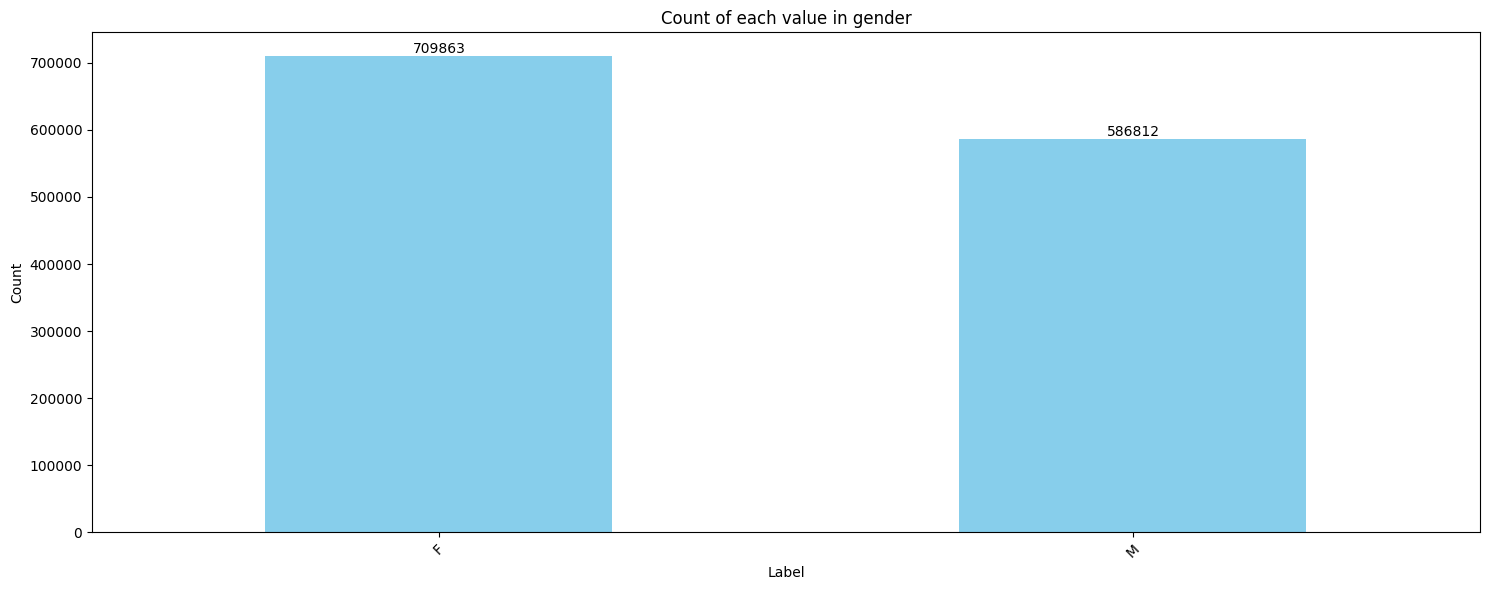

In [154]:
cat_plot(df_viz_2, "gender")

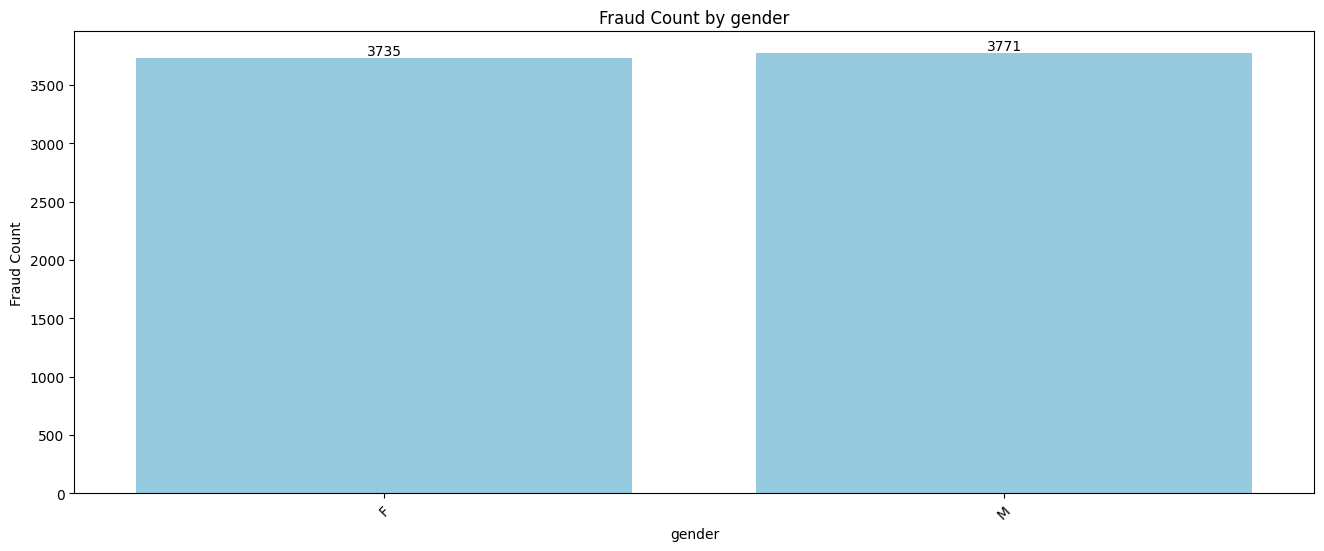

In [153]:
def fraud_countplot(df, column):
    # Count how many frauds per unique value in column
    fraud_counts = df.groupby(column)["is_fraud"].sum().reset_index()

    plt.figure(figsize=(16,6))
    ax = sns.barplot(
        data=fraud_counts,
        x=column,
        y="is_fraud",
        color="skyblue"   # fraud counts in red
    )

    # Add count labels on top of bars
    for p in ax.patches:
        ax.annotate(
            f"{int(p.get_height())}",      # label = fraud count
            (p.get_x() + p.get_width()/2, p.get_height()),  # position at top
            ha="center", va="bottom",
            fontsize=10, color="black", rotation=0
        )

    plt.title(f"Fraud Count by {column}")
    plt.ylabel("Fraud Count")
    plt.xticks(rotation=45)
    plt.show()

fraud_countplot(df_viz_2, "gender")

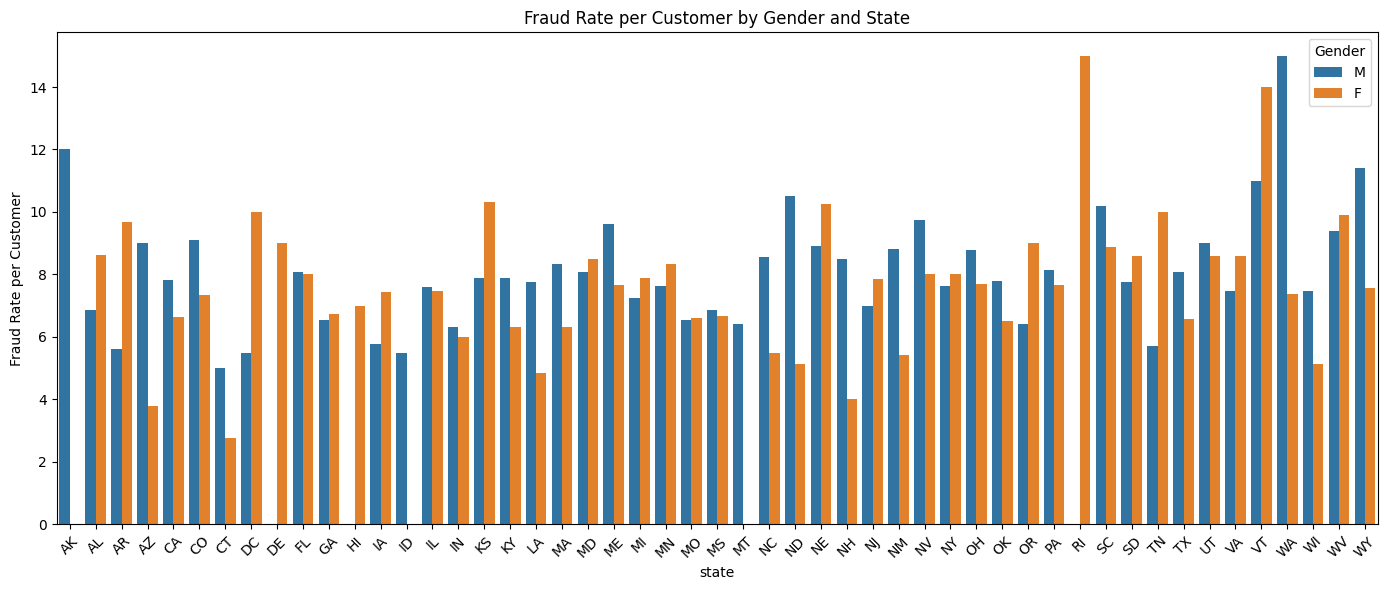

In [143]:

# --- Aggregate fraud per state and gender ---
state_gender_agg = df_viz_2.groupby(["state", "gender"]).agg(
    fraud_sum=("is_fraud", "sum"),
    cust_count=("customer_name", "nunique")  # unique customers
).reset_index()

# Compute fraud rate per customer
state_gender_agg["fraud_rate"] = state_gender_agg["fraud_sum"] / state_gender_agg["cust_count"]

plt.figure(figsize=(14,6))
sns.barplot(
    data=state_gender_agg,
    x="state",
    y="fraud_rate",
    hue="gender"
)
plt.xticks(rotation=45)
plt.ylabel("Fraud Rate per Customer")
plt.title("Fraud Rate per Customer by Gender and State")
plt.legend(title="Gender")
plt.tight_layout()
plt.show()

### Spending patterns based on age groups

In [ ]:
bins = range(0, df_viz_2["age"].max() + 10, 10)
labels = [f"{b}-{b+9}" for b in bins[:-1]]

# --- Aggregate on the fly ---
agg = df_viz_2.groupby([
    pd.cut(df_viz_2["age"], bins=bins, labels=labels, right=False),
    "gender",
    "category"
]).agg(
    total_amt=("amt", "sum")
).reset_index()
agg.rename(columns={"age": "age_group"}, inplace=True)  # optional for clarity

# Plot one chart per category
categories = agg["category"].unique()
for cat in categories:
    cat_data = agg[agg["category"] == cat]

    plt.figure(figsize=(20,6))
    sns.barplot(
        data=cat_data,
        x="age_group",
        y="total_amt",
        hue="gender"
    )
    plt.title(f"Spending for Category: {cat}")
    plt.xlabel("Age Group")
    plt.ylabel("Total Spending")
    plt.xticks(rotation=45)
    plt.legend(title="Gender")
    plt.show()

In [ ]:
# --- Compute median amount ---
median_amt = df_viz_2["amt"].median()

# --- Count high-amount frauds per customer (without modifying df) ---
high_amt_fraud_counts = df_viz_2.loc[(df_viz_2["amt"] > median_amt) & (df_viz_2["is_fraud"] == 1)]
customer_counts = high_amt_fraud_counts.groupby("customer_name").size().reset_index(name="num_high_amt_fraud")

# Average number of high-amount frauds per customer
avg_high_amt_fraud_per_customer = customer_counts["num_high_amt_fraud"].mean()

# Total number of high-amount transactions
total_high_amt = df_viz_2.loc[df_viz_2["amt"] > median_amt].mean()

# Compute ratio
ratio = avg_high_amt_fraud_per_customer*100 / total_high_amt

print(f"Probability that a transaction with higher amount is fradulent: {ratio:.2f}%")

In [177]:
customer_counts

,customer_name,num_high_amt_fraud
0,Aaron Murray,5
1,Aaron Rogers,10
2,Aaron Stewart,6
3,Adam Keller,8
4,Adam Kirk,9
...,...,...
746,William Thompson,9
747,Willie Jordan,4
748,Xavier Beltran,10
749,Zachary Allen,8


# The left

In [ ]:
grouped = (
    df_viz.groupby(["customer_name", "job_1", "job_2"])
    .agg(
        num_cards=("cc_num", "nunique"),  # how many different credit cards used
        fraud_count=("is_fraud", "sum")   # how many fraud cases
    )
    .reset_index()
)

print(grouped.tail())

In [ ]:
grouped = (
    df_viz.groupby("customer_name")
    .agg(
        job_1=("job_1", "first"),
        job_2=("job_2", "first"),
        num_cards=("cc_num", "nunique"),
        total_transactions=("cc_num", "count"),
        total_spent=("amt", "sum"),
        gender=("gender", "first"),
        state=("state", "first"),
        amout = ("amt", "sum"),
        fraud_count=("is_fraud", "sum")
    )
    .reset_index()
)

grouped.shape

In [144]:
top_category = (
    df_viz_2.groupby(["customer_name","gender", "age", "category"])["amt"].sum()
    .reset_index()
    .sort_values(["customer_name", "amt"], ascending=[True, False])
    .drop_duplicates("customer_name")  # keep only top category per customer
    .rename(columns={"category": "top_cat", "amt": "top_category_spent"})
)

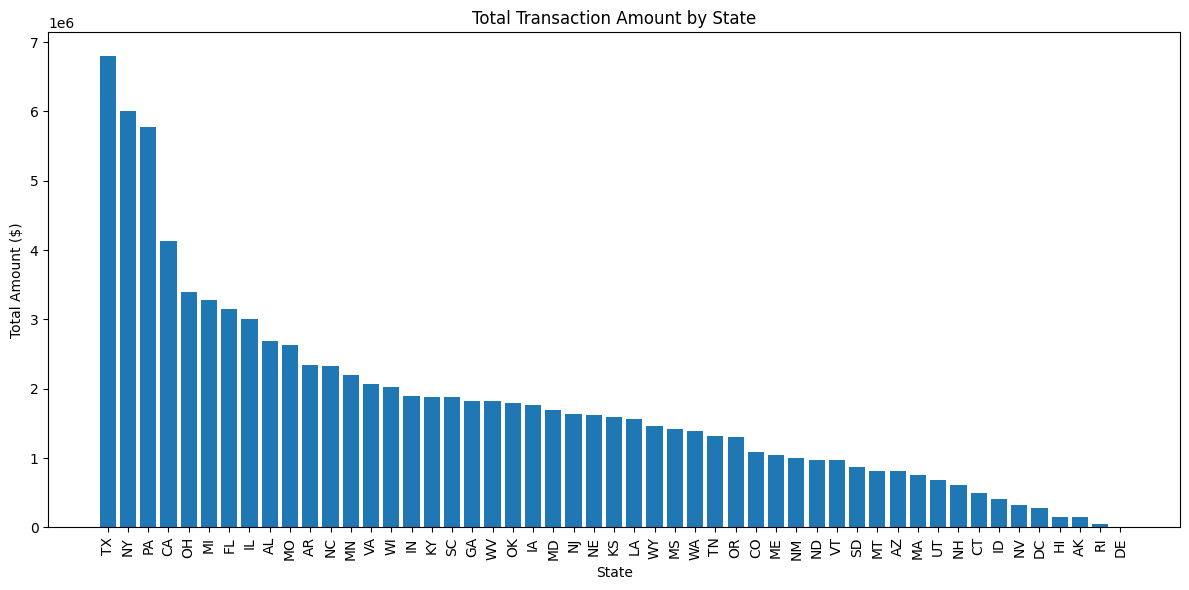

In [145]:
# Example: assuming df has columns 'state' and 'amt'
state_amt = df_viz_2.groupby("state")["amt"].sum().reset_index()

# Sort for better visualization
state_amt = state_amt.sort_values("amt", ascending=False)

# Plot
plt.figure(figsize=(12,6))
plt.bar(state_amt["state"], state_amt["amt"])
plt.xticks(rotation=90)
plt.xlabel("State")
plt.ylabel("Total Amount ($)")
plt.title("Total Transaction Amount by State")
plt.tight_layout()
plt.show()


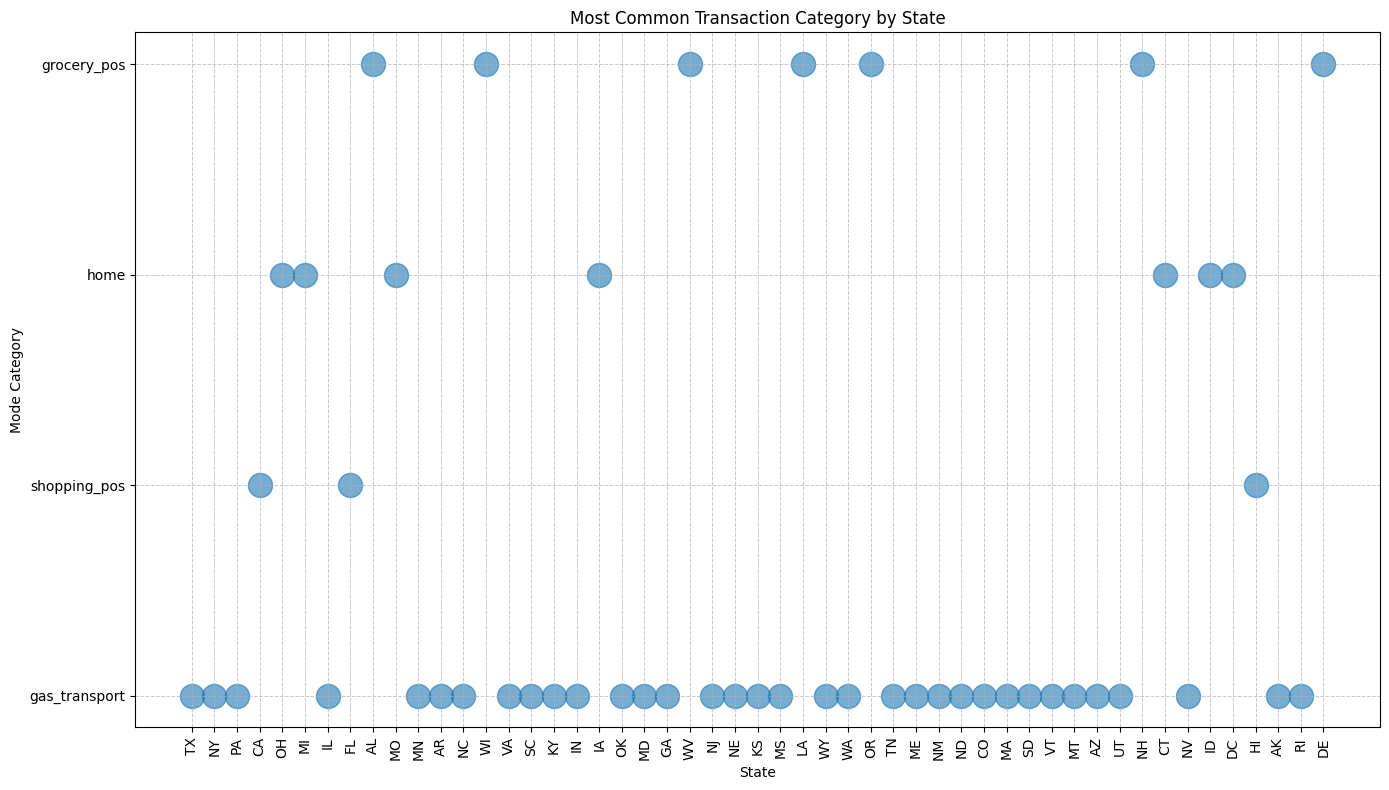

In [146]:
import pandas as pd
import matplotlib.pyplot as plt

def mode_only(x):
    mode_val = x.mode()
    if not mode_val.empty:
        return mode_val[0]
    else:
        return None

state_order = df_viz_2["state"].value_counts().index

# Compute mode per state
state_mode = df_viz_2.groupby("state")["category"].apply(mode_only).reset_index()
state_mode.columns = ["state", "mode_category"]

# Bubble chart (uniform bubble size)
plt.figure(figsize=(14,8))
plt.scatter(
    state_mode["state"],
    state_mode["mode_category"],
    s=300,  # constant bubble size
    alpha=0.6
)

plt.xticks(ticks=range(len(state_order)), labels=state_order, rotation=90)
plt.xticks(rotation=90)
plt.xlabel("State")
plt.ylabel("Mode Category")
plt.title("Most Common Transaction Category by State")

# Add gridlines
plt.grid(True, which="both", linestyle="--", linewidth=0.7, alpha=0.7)

plt.tight_layout()
plt.show()


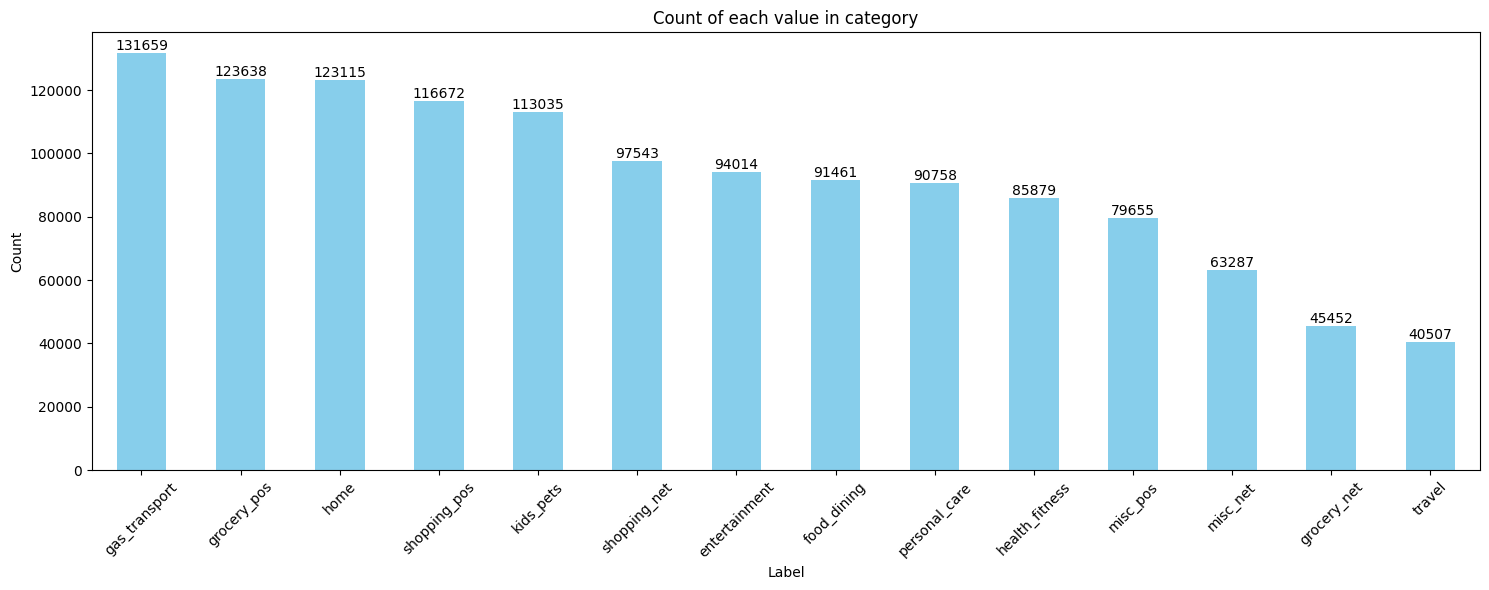

In [147]:
cat_plot(df_viz_2, "category")

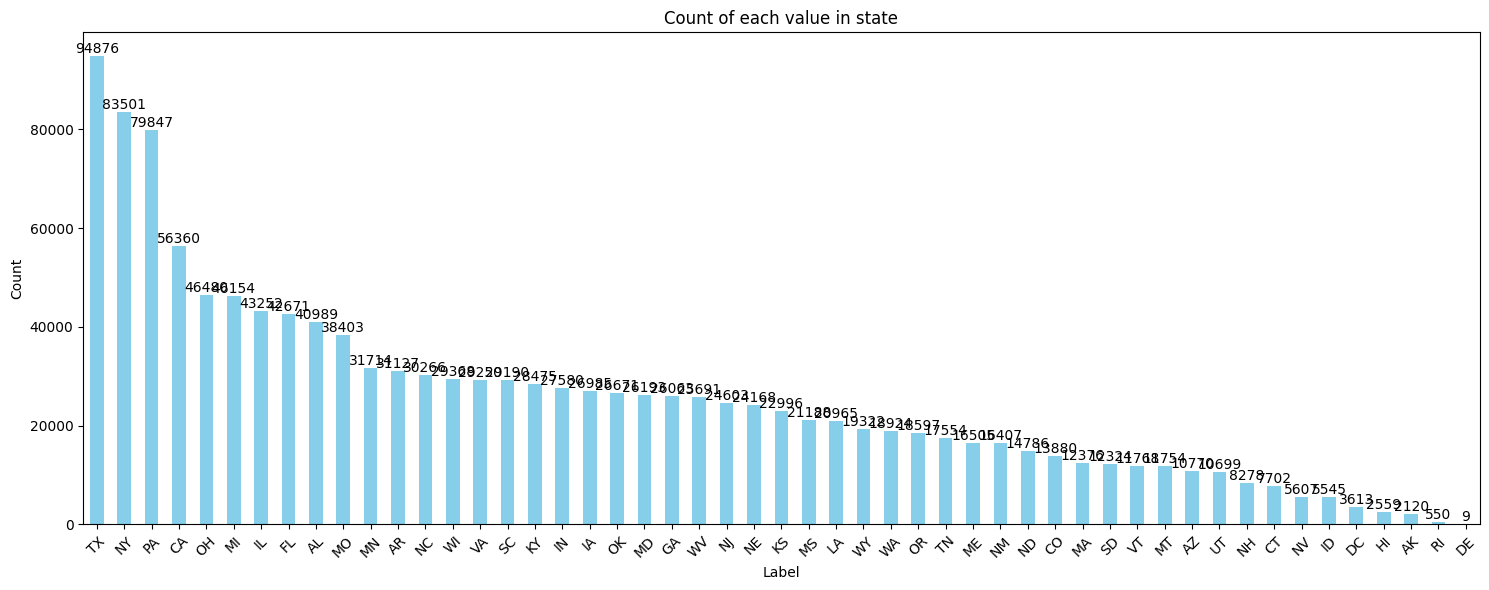

In [148]:
cat_plot(df_viz_2, "state")

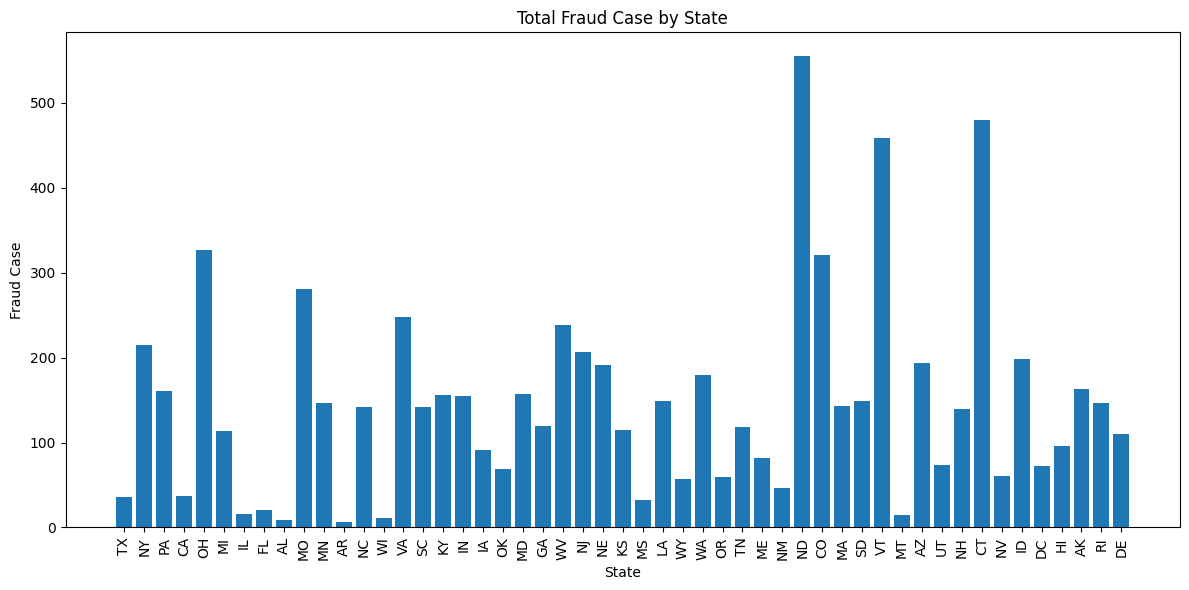

In [149]:
# Example: assuming df has columns 'state' and 'amt'
state_fraud = df_viz_2.groupby("state")["is_fraud"].sum().reset_index()

# Plot
plt.figure(figsize=(12,6))
plt.xticks(ticks=range(len(state_order)), labels=state_order, rotation=90)
plt.bar(state_amt["state"], state_fraud["is_fraud"])
plt.xticks(rotation=90)
plt.xlabel("State")
plt.ylabel("Fraud Case")
plt.title("Total Fraud Case by State")
plt.tight_layout()
plt.show()